In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import backend as K
import cv2
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data loading
def LoadData(frameObj=None, imgPath=None, maskPath=None, shape=128):
    if frameObj is None:
        frameObj = {'img': [], 'mask': []}

    if not (os.path.isdir(imgPath) and os.path.isdir(maskPath)):
        raise ValueError("Image path or mask path is not a valid directory.")

    imgNames = os.listdir(imgPath)
    img_to_mask_map = {}

    for imgName in imgNames:
        baseName = imgName.split('_sat.jpg')[0]
        maskName = baseName + '_mask.png'
        imgFilePath = os.path.join(imgPath, imgName)
        maskFilePath = os.path.join(maskPath, maskName)

        # Check if corresponding mask exists
        if os.path.isfile(maskFilePath):
            img_to_mask_map[imgFilePath] = maskFilePath

    for imgFilePath, maskFilePath in img_to_mask_map.items():
        try:
            img = plt.imread(imgFilePath)
            mask = plt.imread(maskFilePath)
            img = cv2.resize(img, (shape, shape))
            mask = cv2.resize(mask, (shape, shape))

            # Ensure mask is binary and has only one channel
            if mask.ndim == 3:
                mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)

            mask = (mask > 0).astype(np.float32)  # Binarize mask

            frameObj['img'].append(img / 255.0)  # Normalize images
            frameObj['mask'].append(mask[..., np.newaxis])  # Expand dimensions

        except Exception as e:
            print(f"An error occurred with file {imgFilePath} or {maskFilePath}: {e}")

    return frameObj


In [ ]:
imgPath = '/content/drive/MyDrive/Colab Notebooks/DeepGlobe/train/'
maskPath = '/content/drive/MyDrive/Colab Notebooks/DeepGlobe/train_labels/'
framObjTrain = {'img': [], 'mask': []}
framObjTrain = LoadData(frameObj=framObjTrain, imgPath=imgPath, maskPath=maskPath, shape=128)


In [49]:
print(len(framObjTrain['img']))
print(len(framObjTrain['mask']))

18523
18523


In [6]:

# defining Conv2d block for our u-net
def Conv2dBlock(inputTensor, numFilters, kernelSize=3, doBatchNorm=True):
    x = tf.keras.layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                               kernel_initializer='he_normal', padding='same')(inputTensor)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters=numFilters, kernel_size=(kernelSize, kernelSize),
                               kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def GiveMeUnet(inputImage, numFilters=16, droupouts=0.1, doBatchNorm=True):
    # Encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)

    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)

    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)

    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)

    #Bottleneck
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize=3, doBatchNorm=doBatchNorm)

    # Decoder Path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize=3, doBatchNorm=doBatchNorm)

    u7 = tf.keras.layers.Conv2DTranspose(numFilters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize=3, doBatchNorm=doBatchNorm)

    u8 = tf.keras.layers.Conv2DTranspose(numFilters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize=3, doBatchNorm=doBatchNorm)

    u9 = tf.keras.layers.Conv2DTranspose(numFilters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize=3, doBatchNorm=doBatchNorm)

    output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = tf.keras.Model(inputs=[inputImage], outputs=[output])
    return model

In [7]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value


def f1_score(y_true, y_pred):
    precision_value = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall_value = recall(y_true, y_pred)
    f1_value = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1_value


In [8]:
# Model Compilation
inputs = tf.keras.layers.Input((128, 128, 3))
unet = GiveMeUnet(inputs, droupouts=0.07)
unet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), recall, f1_score]
)


In [12]:
# Training
framObjTrain = LoadData(framObjTrain, imgPath=imgPath, maskPath=maskPath, shape=128)
retVal = unet.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), batch_size=16, epochs=40, verbose=1)


Epoch 1/40
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.9802 - f1_score: 0.7736 - loss: 0.0490 - precision: 0.8272 - recall: 0.7289
Epoch 2/40
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9805 - f1_score: 0.7758 - loss: 0.0481 - precision: 0.8283 - recall: 0.7320
Epoch 3/40
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9809 - f1_score: 0.7831 - loss: 0.0471 - precision: 0.8326 - recall: 0.7413
Epoch 4/40
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9810 - f1_score: 0.7826 - loss: 0.0468 - precision: 0.8320 - recall: 0.7411
Epoch 5/40
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9813 - f1_score: 0.7878 - loss: 0.0458 - precision: 0.8344 - recall: 0.7483
Epoch 6/40
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9816 - f1_score: 0.7891 - loss: 0.0450 - precision: 0.8358 - recall: 0.7498
Epoch 7/40
1158/1158 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.9819 - f1_score: 0.7921 - loss: 0.0444 - precision: 0.

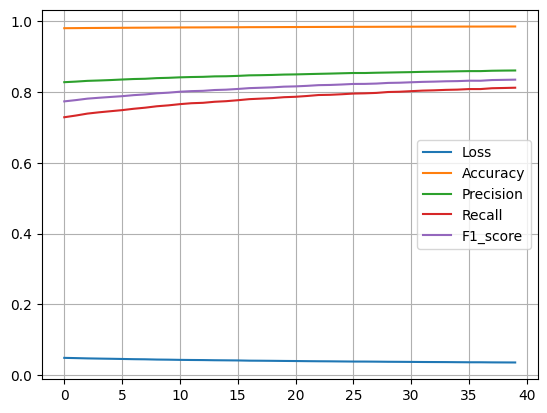

In [43]:
plt.plot(retVal.history['loss'], label='Loss')
plt.plot(retVal.history['accuracy'], label='Accuracy')
plt.plot(retVal.history['precision'], label='Precision')
plt.plot(retVal.history['recall'], label='Recall')
plt.plot(retVal.history['f1_score'], label='F1_score')
plt.legend()
plt.grid(True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


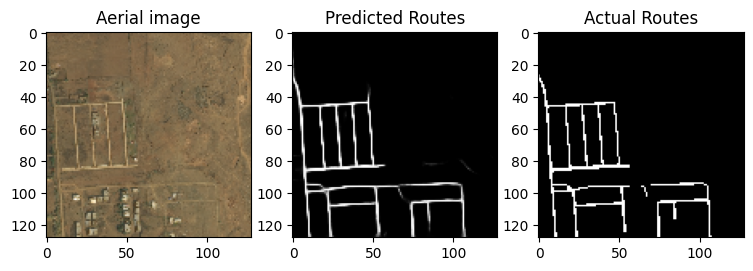

In [14]:
def predict16(valMap, model, shape=128):
    img = valMap['img'][0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    return predictions, imgProc, valMap['mask'][0:16]

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9, 9))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Aerial image')

    plt.subplot(1, 3, 2)
    plt.imshow(predMask, cmap='gray')
    plt.title('Predicted Routes')

    plt.subplot(1, 3, 3)
    plt.imshow(groundTruth, cmap='gray')
    plt.title('Actual Routes')

# Generate Predictions
sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)
Plotter(actuals[1], sixteenPrediction[1][:, :, 0], masks[1])

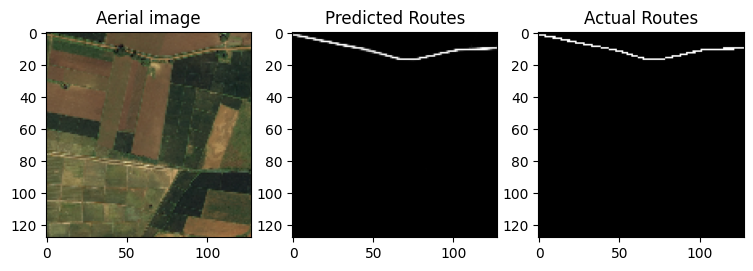

In [16]:
Plotter(actuals[15], sixteenPrediction[15][:,:,0], masks[15])

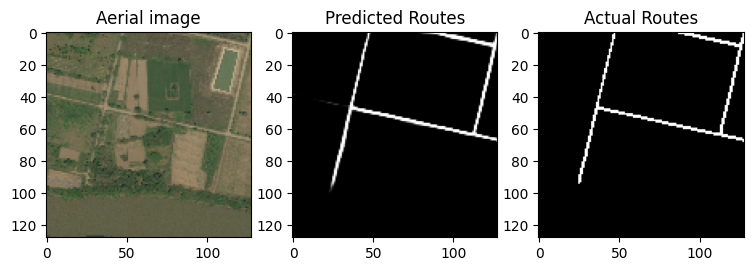

In [17]:
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

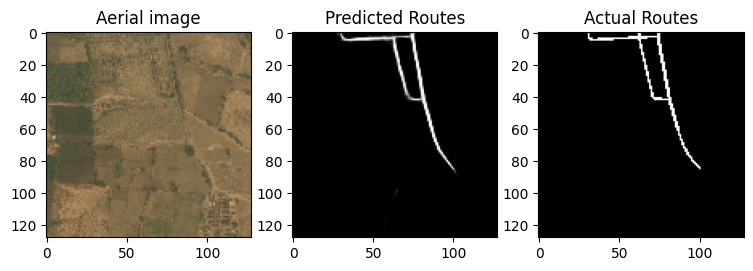

In [18]:
Plotter(actuals[8], sixteenPrediction[8][:,:,0], masks[8])

In [20]:
avg_loss = np.mean(retVal.history['loss'])
avg_precision = np.mean(retVal.history['precision'])
avg_accuracy = np.mean(retVal.history['accuracy'])
avg_f1_score = np.mean(retVal.history['f1_score'])
avg_recall = np.mean(retVal.history['recall'])
print(f'Average Loss: {avg_loss:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average F1 Score: {avg_f1_score:.4f}')
print(f'Average Recall: {avg_recall:.4f}')

Average Loss: 0.0407
Average Precision: 0.8478
Average Accuracy: 0.9832
Average F1 Score: 0.8119
Average Recall: 0.7810


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


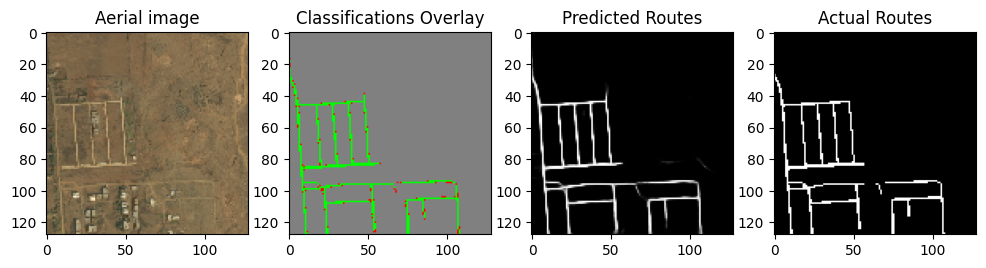

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to overlay road, non-road, and low-certainty pixels on the actual image
def overlay_classifications_on_aerial(img, predMask):
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)


    overlay_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    road_thresh = 0.6  # Above = classified as a road
    non_road_thresh = 0.4  # Below = classified as non-road
    low_certainty_thresh = 0.5  # Between this range is low-certainty

    # Resize the prediction mask to match the aerial image
    mask_resized = cv2.resize(predMask, (img.shape[1], img.shape[0]))

    road_pixels = mask_resized >= road_thresh
    non_road_pixels = mask_resized <= non_road_thresh
    low_certainty_pixels = (mask_resized > non_road_thresh) & (mask_resized < road_thresh)


    overlay_image[road_pixels] = [0, 255, 0]
    overlay_image[low_certainty_pixels] = [255, 0, 0]
    overlay_image[non_road_pixels] = [128, 128, 128]

    return overlay_image

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(12, 9))

    # Aerial image
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.title('Aerial image')

    # Classified pixels overlaid on the actual aerial image
    overlay_image = overlay_classifications_on_aerial(img, predMask)
    plt.subplot(1, 4, 2)
    plt.imshow(overlay_image)
    plt.title('Classifications Overlay')

    # Predicted Routes
    plt.subplot(1, 4, 3)
    plt.imshow(predMask, cmap='gray')
    plt.title('Predicted Routes')

    # Ground truth (Actual Routes)
    plt.subplot(1, 4, 4)
    plt.imshow(groundTruth, cmap='gray')
    plt.title('Actual Routes')

    plt.show()

sixteenPrediction, actuals, masks = predict16(framObjTrain, unet)
Plotter(actuals[1], sixteenPrediction[1][:, :, 0], masks[1])


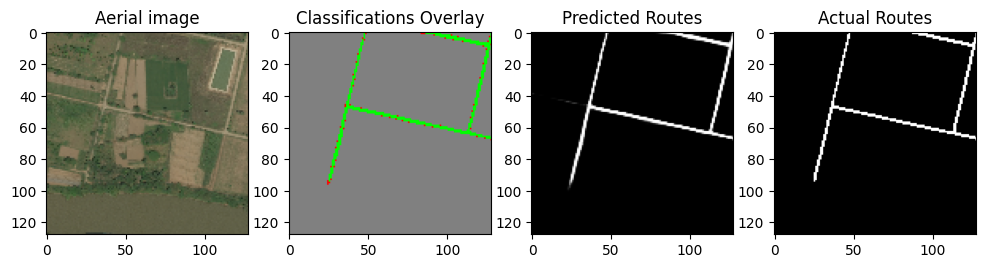

In [40]:
Plotter(actuals[2], sixteenPrediction[2][:, :, 0], masks[2])

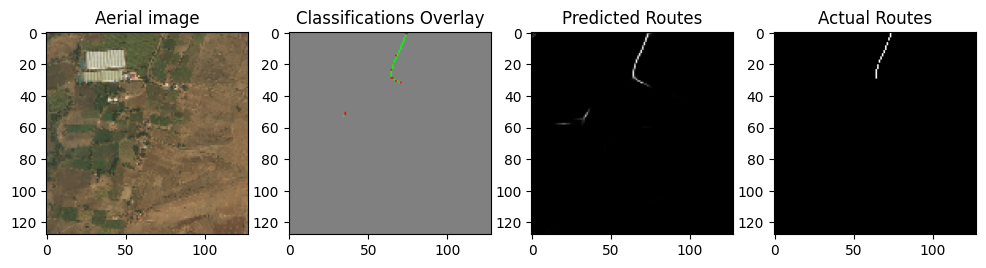

In [41]:
Plotter(actuals[6], sixteenPrediction[6][:, :, 0], masks[6])

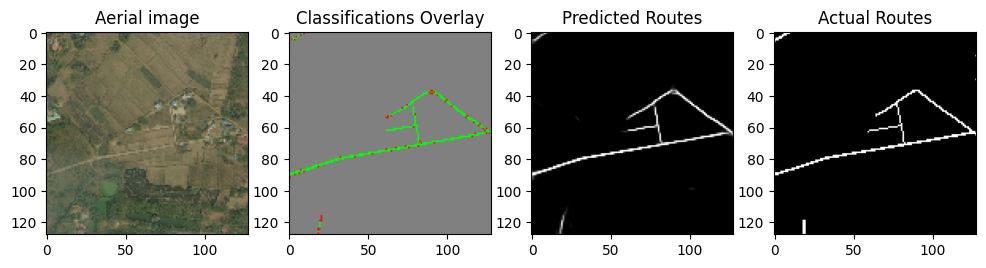

In [37]:
Plotter(actuals[4], sixteenPrediction[4][:, :, 0], masks[4])

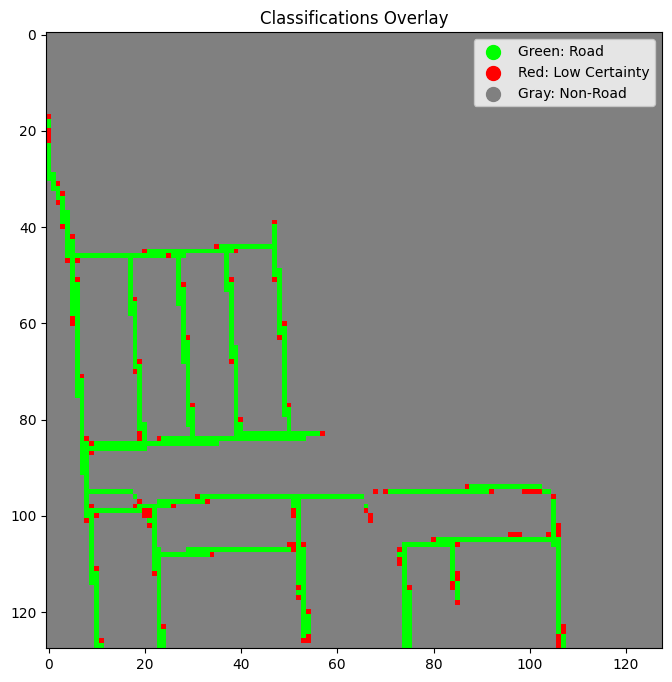

In [24]:
def overlay_classifications_on_aerial(img, predMask):
    # Ensure predMask is normalized
    if predMask.max() > 1.0:
        predMask = predMask / 255.0


    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    overlay_image = img.copy()

    # Threshold values to classify road, non-road, and low-certainty pixels
    road_thresh = 0.6
    non_road_thresh = 0.4

    # Resize the prediction mask to match the aerial image
    mask_resized = cv2.resize(predMask, (img.shape[1], img.shape[0]))

    # Create binary masks for each class
    road_pixels = mask_resized >= road_thresh
    low_certainty_pixels = (mask_resized > non_road_thresh) & (mask_resized < road_thresh)
    non_road_pixels = mask_resized <= non_road_thresh

    # Apply colors for each classification directly on the original image
    overlay_image[road_pixels] = [0, 255, 0]
    overlay_image[low_certainty_pixels] = [255, 0, 0]
    overlay_image[non_road_pixels] = [128, 128, 128]

    return overlay_image


img = actuals[1]
pred_mask = sixteenPrediction[1][:, :, 0]

overlay_image = overlay_classifications_on_aerial(img, pred_mask)

plt.figure(figsize=(8, 8))
plt.imshow(overlay_image)
plt.title('Classifications Overlay')
plt.axis('on')  # Show axis

# Add a legend for the colors
legend_labels = ['Green: Road', 'Red: Low Certainty', 'Gray: Non-Road']
colors = [[0, 255, 0], [255, 0, 0], [128, 128, 128]]

# Create custom legend with the specified colors
for i in range(len(legend_labels)):
    plt.scatter([], [], color=np.array(colors[i]) / 255.0, label=legend_labels[i], s=100)  # Convert to [0, 1] range

plt.legend(loc='upper right', fontsize=10)
plt.show()


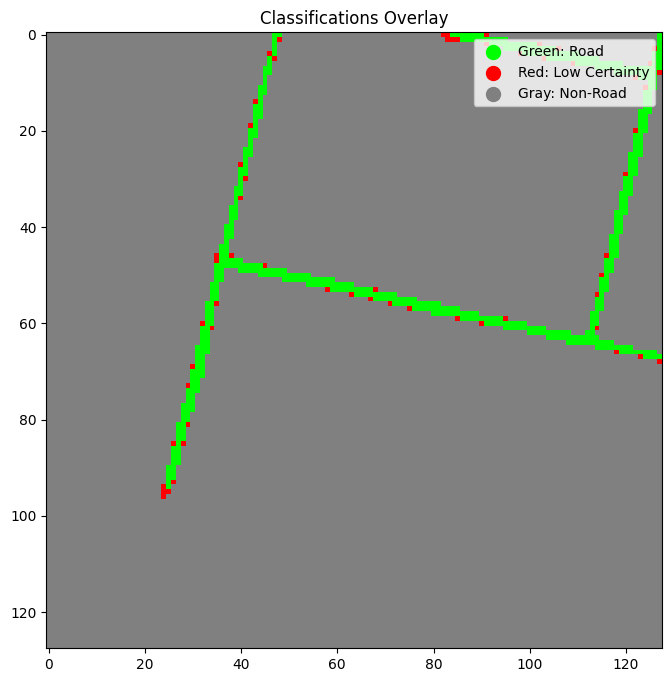

In [25]:
img = actuals[2]
pred_mask = sixteenPrediction[2][:, :, 0]


overlay_image = overlay_classifications_on_aerial(img, pred_mask)


plt.figure(figsize=(8, 8))
plt.imshow(overlay_image)
plt.title('Classifications Overlay')
plt.axis('on')


legend_labels = ['Green: Road', 'Red: Low Certainty', 'Gray: Non-Road']
colors = [[0, 255, 0], [255, 0, 0], [128, 128, 128]]

# Create custom legend with the specified colors
for i in range(len(legend_labels)):
    plt.scatter([], [], color=np.array(colors[i]) / 255.0, label=legend_labels[i], s=100)

plt.legend(loc='upper right', fontsize=10)
plt.show()

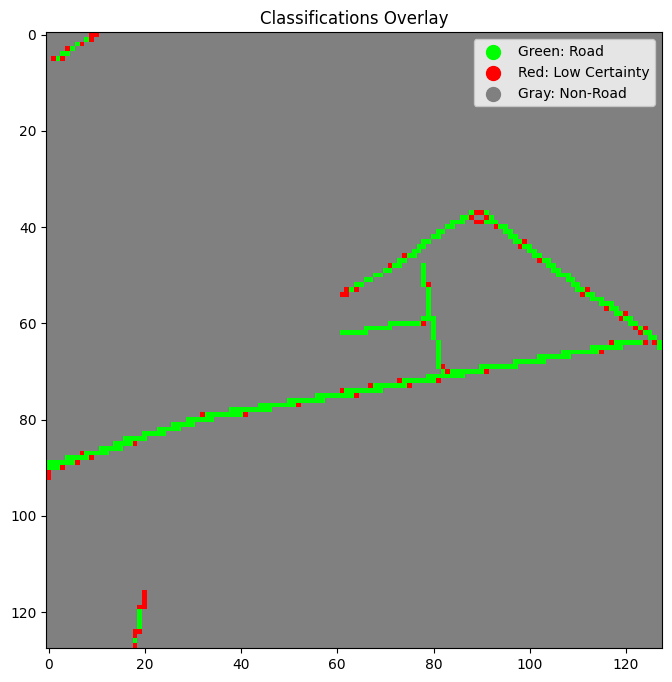

In [26]:
# Assuming img and pred_mask are defined
img = actuals[4]
pred_mask = sixteenPrediction[4][:, :, 0]

# Generate the overlay image
overlay_image = overlay_classifications_on_aerial(img, pred_mask)

# Display the overlay image with labels
plt.figure(figsize=(8, 8))
plt.imshow(overlay_image)
plt.title('Classifications Overlay')
plt.axis('on')  # Show axis

# Add a legend for the colors
legend_labels = ['Green: Road', 'Red: Low Certainty', 'Gray: Non-Road']
colors = [[0, 255, 0], [255, 0, 0], [128, 128, 128]]

# Create custom legend with the specified colors
for i in range(len(legend_labels)):
    plt.scatter([], [], color=np.array(colors[i]) / 255.0, label=legend_labels[i], s=100)  # Convert to [0, 1] range

plt.legend(loc='upper right', fontsize=10)
plt.show()

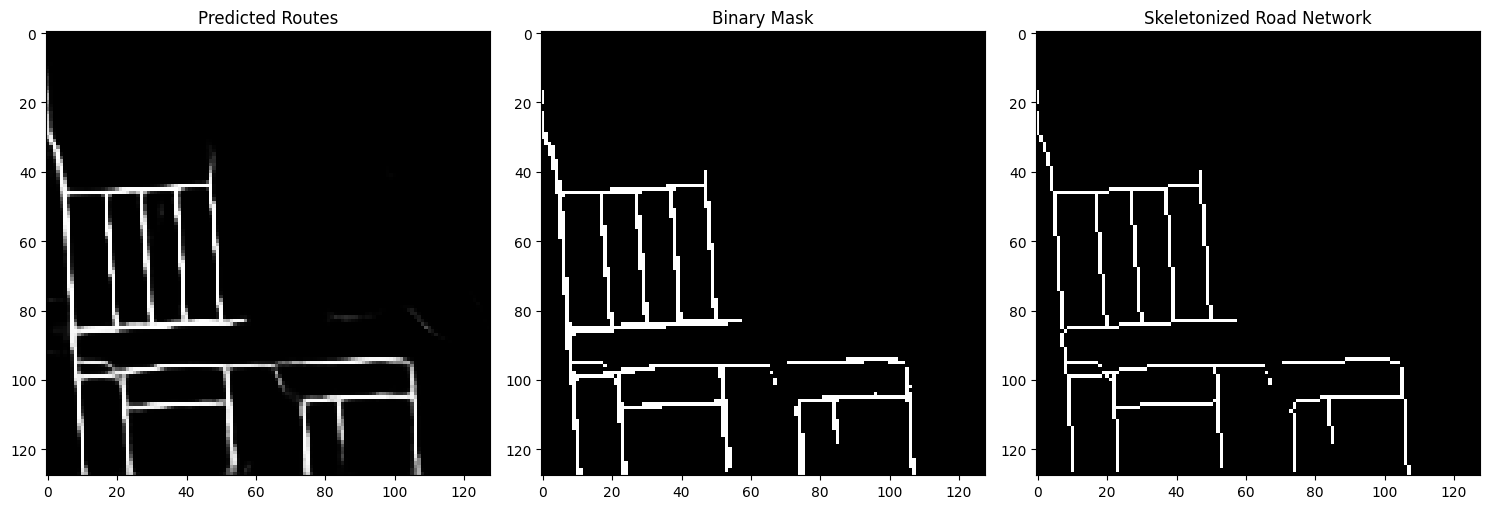

In [27]:
# Use the selected index to get the predicted and actual images
index = 1
predicted_image = sixteenPrediction[index][:, :, 0]
actual_image = actuals[index]
ground_truth_mask = masks[index]

# Convert the predicted mask to a binary mask (threshold at 0.5)
_, binary_mask = cv2.threshold(predicted_image, 0.5, 1, cv2.THRESH_BINARY)

# Skeletonize the binary mask
skeleton = skeletonize(binary_mask)

# Plotting the original, binary, and skeletonized images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(predicted_image, cmap='gray')
plt.title('Predicted Routes')

plt.subplot(1, 3, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')

plt.subplot(1, 3, 3)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeletonized Road Network')

plt.tight_layout()
plt.show()


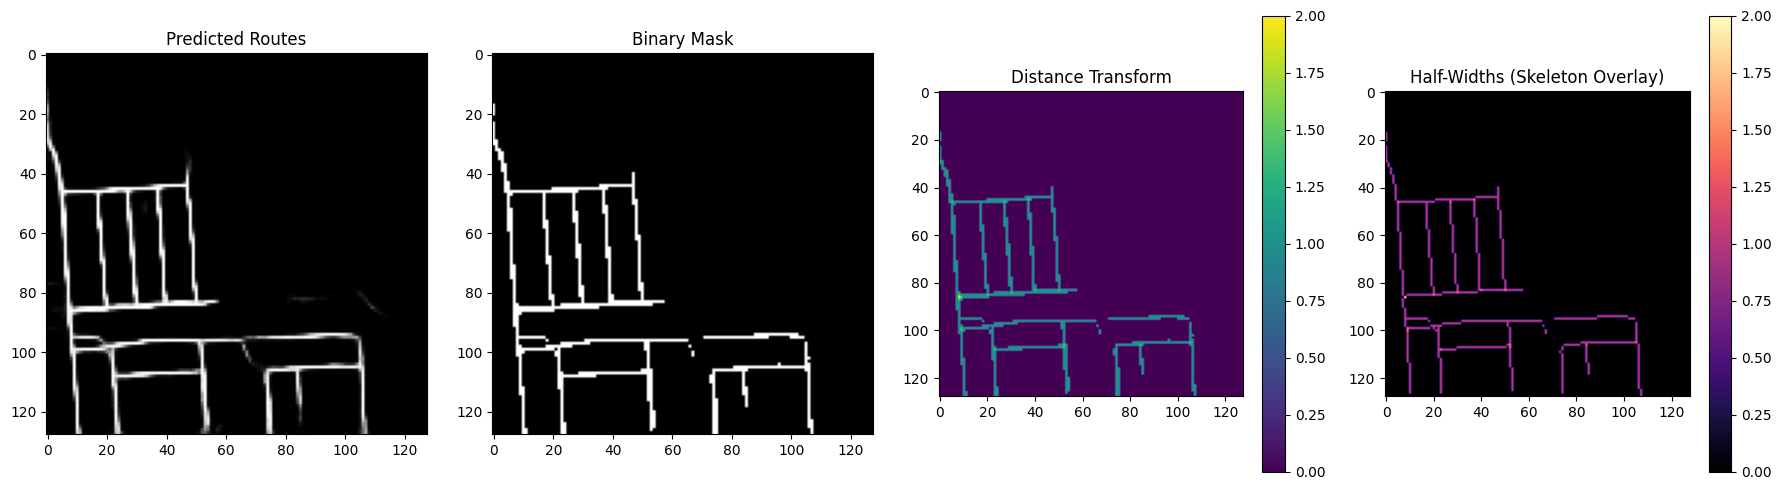

In [28]:


# Use the selected index to get the predicted and actual images
index = 1
predicted_image = sixteenPrediction[index][:, :, 0]
actual_image = actuals[index]
ground_truth_mask = masks[index]

# Convert the predicted mask to a binary mask (threshold at 0.5)
_, binary_mask = cv2.threshold(predicted_image, 0.5, 1, cv2.THRESH_BINARY)

# Skeletonize the binary mask
skeleton = skeletonize(binary_mask)


distance_transform = distance_transform_edt(binary_mask)


half_widths = distance_transform * skeleton

plt.figure(figsize=(18, 5))

plt.subplot(1, 4, 1)
plt.imshow(predicted_image, cmap='gray')
plt.title('Predicted Routes')

plt.subplot(1, 4, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Binary Mask')

plt.subplot(1, 4, 3)
plt.imshow(distance_transform, cmap='viridis')
plt.colorbar()
plt.title('Distance Transform')

plt.subplot(1, 4, 4)
plt.imshow(half_widths, cmap='magma')
plt.colorbar()
plt.title('Half-Widths (Skeleton Overlay)')

plt.tight_layout()
plt.show()


In [50]:

index = 1
GSD = 0.5 #Resolution of image

# Use the selected index to get the predicted and actual images
predicted_image = sixteenPrediction[index][:, :, 0]
actual_image = actuals[index]
ground_truth_mask = masks[index]


_, binary_mask = cv2.threshold(predicted_image, 0.5, 1, cv2.THRESH_BINARY)

# Skeletonize the binary mask
skeleton = skeletonize(binary_mask)
# Perform distance transform to get the half-widths
distance_transform = cv2.distanceTransform(binary_mask.astype(np.uint8), cv2.DIST_L2, 3)

# Multiply with the skeleton to get the widths at each centerline pixel
road_widths = distance_transform * skeleton

# Calculate road width statistics and convert to meters
non_zero_widths = road_widths[road_widths > 0]
average_width_meters = np.mean(non_zero_widths) * 2 * GSD
min_width_meters = np.min(non_zero_widths) * 2 * GSD
max_width_meters = np.max(non_zero_widths) * 2 * GSD


print(f"Image Index: {index}")
print(f"Average Road Width: {average_width_meters:.2f} meters")
print(f"Minimum Road Width: {min_width_meters:.2f} meters")
print(f"Maximum Road Width: {max_width_meters:.2f} meters")


road_surface_area_pixels = np.sum(binary_mask)
road_surface_area_meters = road_surface_area_pixels * (GSD ** 2)
print(f"Total Road Surface Area: {road_surface_area_meters:.2f} square meters")


Image Index: 1
Average Road Width: 0.97 meters
Minimum Road Width: 0.95 meters
Maximum Road Width: 1.91 meters
Total Road Surface Area: 215.50 square meters


In [45]:
!nvidia-smi

Sat Oct 26 14:27:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   76C    P0              35W /  72W |   8473MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [46]:
!lscpu |grep 'Model name'

Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz
